##### Load Dependencies

In [ ]:
import os
import numpy as np
import pandas as pd
from boogr import Error, ErrorDialog
from openai import OpenAI
from pydantic import BaseModel
import seaborn as sns
import sklearn
from sklearn import datasets
from sklearn.metrics import classification_report, r2_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier, Ridge, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import ipywidgets as widgets, IPython, platform, ipywidgets, jupyterlab

from models import y_pred_lr_cls
from static import Requests, Roles, Languages
from boogr import Error, ErrorDialog, ChatWindow, FileDialog, FileBrowser
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mlxtend.plotting import scatterplotmatrix, heatmap
from typing import Any, List, Tuple, Optional, Dict
import warnings

In [ ]:
hdr = '\r\n' + '-' * 140
nwln = '\r\n'
warnings.filterwarnings( 'ignore' )

##### Perceptron

In [ ]:
class Perceptron( ):
	'''


		Purpose
		________

		Class to train models via fit function


		Parameters
		------------
		eta : float
		Learning rate (between 0.0 and 1.0)
		n_iter : int
		Passes over the training dataset.
		random_state : int
		Random num generator seed for random weight
		initialization.


		Attributes
		-----------
		w_ : 1d-array
		Weights after fitting.
		b_ : Scalar
		Bias unit after fitting.
		errors_ : list
		Number of misclassifications (updates) in each epoch.


	'''


	def __init__( self, eta=0.01, n_iter=50, random_state=42 ):
		"""

			Purpose
			_______
			Initializes PerceptronClassifier opbjects


			Parameters
			----------
			eta: flaot.
			The rate rate (between 0.0 and 1.0)

			n_iter: int
			Target target_values.

			random_state: int
			Epochs.

			Returns
			-------
			self : object

		"""
		self.eta = eta
		self.n_iter = n_iter
		self.random_state = random_state


	def fit( self, X, y ):
		"""

			Purpose
			_______
			Fit training target_values.


			Parameters
			----------
			X : {array-like}, shape = [n_examples, n_features]
			Training vec, where n_examples is the num of
			examples and n_features is the num of features.

			y : array-like, shape = [n_examples]
			Target target_values.

			Returns
			-------
			self : object

		"""
		try:
			if X is None:
				raise Exception( 'target_values is not provided.' )
			elif y is None:
				raise Exception( 'y is not provided.' )
			else:
				rgen = np.random.RandomState( self.random_state )
				self.w_ = rgen.normal( loc=0.0, scale=0.01, size=X.shape[ 1 ] )
				self.b_ = np.float64( 0. )
				self.errors_ = [ ]

				for _ in range( self.n_iter ):
					errors = 0

				for xi, target in zip( X, y ):
					update = self.eta * ( target - self.predict( xi ) )

				self.w_ += update * xi
				self.b_ += update
				errors += int( update != 0.0 )
				self.errors_.append( errors )
				return self
		except Exception as e:
			exception = Error( e )
			exception.module = 'Boo'
			exception.cause = 'PerceptronClassifier'
			exception.method = 'fit( self, X y )'
			error = ErrorDialog( exception )
			error.show( )


	def net_input( self, X ):
		"""

			Purpose
			_______
			Calculates net path

			Parameters
			----------
			X : {array-like}, shape = [n_examples, n_features]
			Training vec, where n_examples is the num of
			examples and n_features is the num of features.


			Returns
			-------
			np.array

		"""
		try:
			if X is None:
				raise Exception( 'Aurguent "X" is not provided.' )
			else:
				return np.dot( X, self.w_ ) + self.b_
		except Exception as e:
			exception = Error( e )
			exception.module = 'Boo'
			exception.cause = 'PerceptronClassifier'
			exception.method = 'net_input( self, X ):'
			error = ErrorDialog( exception )
			error.show( )


	def predict( self, X ):
		"""

			Purpose
			_______
			Calculates prediction

			Parameters
			----------
			X : {array-like}, shape = [n_examples, n_features]
			Training vec, where n_examples is the num of
			examples and n_features is the num of features.


			Returns
			-------
			np.array

		"""
		try:
			if X is None:
				raise Exception( 'Aurguent "X" is not provided.' )
			else:
				return np.where( self.net_input( X ) >= 0.0, 1, 0 )
		except Exception as e:
			exception = Error( e )
			exception.module = 'Boo'
			exception.cause = 'PerceptronClassifier'
			exception.method = 'predict( self, X )'
			error = ErrorDialog( exception )
			error.show( )


	def __dir__( self ) -> List[ str ]:
		'''
			Methods that returns a get_list of member names
			Returns: get_list[ str ]
		'''
		return [ 'fit', 'net_input', 'predict',
		         'w_', 'b_', 'errors_',
		         'n_iter', 'rando', 'eta' ]

##### LinearGradientDescent

In [ ]:
class LinearGradientDescent( ):
	"""

		Purpose
		___________
		Adaptive Linear Neuron classifier.

		Parameters
		------------
		eta : float
		Learning rate (between 0.0 and 1.0)
		n_iter : int
		Passes over the training dataset.
		random_state : int
		Random num generator seed for random weight initialization.

		Attributes
		-----------
		w_ : 1d-array
		Weights after fitting.
		b_ : Scalar
		Bias unit after fitting.
		losses_ : list
		Mean squared error loss function target_values in each epoch.

	"""


	def __init__( self, eta=0.01, n_iter=50, random_state=1 ):
		"""

			Purpose
			_______
			Initializes LinearRegression opbjects


			Parameters
			----------
			eta: flaot=0.01
			The rate rate (between 0.0 and 1.0)

			n_iter: int: 50
			Target target_values.

			random_state: int:1
			Epochs.

			Returns
			-------
			self : object

		"""
		self.eta = eta
		self.n_iter = n_iter
		self.random_state = random_state


	def fit( self, X, y ):
		"""

			Fit training target_values.

			Parameters
			----------
			X : {array-like}, shape = [n_examples, n_features]
			Training vec, where n_examples
			is the num of examples and
			n_features is the num of features.

			y : array-like, shape = [n_examples]
			Target target_values.

			Returns
			-------
			self : object

		"""
		try:
			if X is None:
				raise Exception( 'Aurguent "X" is not provided.' )
			elif y is None:
				raise Exception( 'y is not provided.' )
			else:
				rgen = np.random.RandomState( self.random_state )
				self.w_ = rgen.normal( loc=0.0, scale=0.01,
					size=X.shape[ 1 ] )
				self.b_ = np.float_( 0. )
				self.losses_ = [ ]
				for i in range( self.n_iter ):
					net_input = self.net_input( X )

				output = self.activation( net_input )
				errors = (y - output)
				self.w_ += self.eta * 2.0 * X.T.dot( errors ) / X.shape[ 0 ]
				self.b_ += self.eta * 2.0 * errors.mean( )
				loss = (errors ** 2).mean( )
				self.losses_.append( loss )
				return self
		except Exception as e:
			exception = Error( e )
			exception.module = 'Boo'
			exception.cause = 'LinearRegression'
			exception.method = 'fit( self, X, y )'
			error = ErrorDialog( exception )
			error.show( )


	def net_input( self, X ):
		"""

			Purpose
			_______
			Calculates net path

			Parameters
			----------
			X : {array-like}, shape = [n_examples, n_features]
			Training vec, where n_examples is the num of
			examples and n_features is the num of features.


			Returns
			-------
			np.array

		"""
		try:
			if X is None:
				raise Exception( 'target_values is not provided.' )
			else:
				return np.dot( X, self.w_ ) + self.b_
		except Exception as e:
			exception = Error( e )
			exception.module = 'Boo'
			exception.cause = 'LinearRegression'
			exception.method = 'net_input( self, X )'
			error = ErrorDialog( exception )
			error.show( )


	def activation( self, X ):
		"""

			Purpose
			_______
			Computes linear activation

			Parameters
			----------
			X : {array-like}, shape = [n_examples, n_features]
			Training vec, where n_examples is the num of
			examples and n_features is the num of features.


			Returns
			-------
			X : {array-like}, shape = [n_examples, n_features]
			Training vec, where n_examples is the num of
			examples and n_features is the num of features.

		"""
		try:
			if X is None:
				raise Exception( 'Aurguent "X" is not provided.' )
			else:
				return X
		except Exception as e:
			exception = Error( e )
			exception.module = 'Boo'
			exception.cause = 'LinearRegression'
			exception.method = 'activation( self, X )'
			error = ErrorDialog( exception )
			error.show( )


	def predict( self, X ):
		"""

			Purpose
			_______
			Computes linear activation

			Parameters
			----------
			X : {array-like}, shape = [n_examples, n_features]
			Training vec, where n_examples is the num of
			examples and n_features is the num of features.


			Returns
			-------
			np.array

		"""
		try:
			if X is None:
				raise Exception( 'Aurguent "X" is not provided.' )
			else:
				return np.where( self.activation( self.net_input( X ) ) >= 0.5, 1, 0 )
		except Exception as e:
			exception = Error( e )
			exception.module = 'Boo'
			exception.cause = 'LinearRegression'
			exception.method = 'predict( self, target_values )'
			error = ErrorDialog( exception )
			error.show( )


	def __dir__( self ) -> list[ str ]:
		'''

			Methods that returns a get_list of member names
			Returns: get_list[ str ]

		'''
		return [ 'fit', 'net_input', 'activation',
		         'predict', 'losses_', 'b_', 'w_',
		         'n_iter', 'eta', 'rando'  ]

##### StochasticGradientDescent

In [ ]:
class StochasticGradientDescent:
	"""

		Purpose:
		____________
		Adaptive Linear Neuron Classifier.

		Parameters
		------------
		eta : float
		Learning rate (between 0.0 and 1.0)
		n_iter : int
		Passes over the training dataset.
		shuffle : bool (default: True)
		Shuffles training df every epoch if True to prevent
		cycles.
		random_state : int
		Random number generator seed for random weight
		initialization.

		Attributes
		-----------
		w_ : 1d-array
		Weights after fitting.

		b_ : Scalar
		Bias unit after fitting.

		losses_ : list
		Mean squared error loss function value averaged over all
		training examples in each epoch.

	"""
	def __init__( self, eta=0.01, n_iter=10, shuffle=True, random_state=None ):
		self.eta = eta
		self.n_iter = n_iter
		self.w_initialized = False
		self.shuffle = shuffle
		self.random_state = random_state


	def fit(self, X, y):
		"""

			Purpose:
			__________
			Fit training df.

			Parameters
			----------
			X : {array-like}, shape = [n_examples, n_features]
			Training vectors, where n_examples is the number of
			examples and n_features is the number of features.
			y : array-like, shape = [n_examples]
			Target target_values.

			Returns
			-------
			self : object

		"""
		self._initialize_weights(X.shape[1])
		self.losses_ = []
		for i in range(self.n_iter):
			if self.shuffle:
				X, y = self._shuffle(X, y)
		losses = []
		for xi, target in zip(X, y):
			losses.append(self._update_weights(xi, target))
			avg_loss = np.mean(losses)
			self.losses_.append(avg_loss)
			return self


	def partial_fit( self, X, y ):
		"""

			Fit training df
			without reinitializing the weights

		"""
		if not self.w_initialized:
			self._initialize_weights( X.shape[ 1 ] )
			if y.ravel( ).shape[ 0 ] > 1:
				for xi, target in zip( X, y ):
					self._update_weights( xi, target )
			else:
				self._update_weights( X,  y)
				return self


	def _shuffle(self, X, y):
		"""

			Shuffle training df

		"""
		r = self.rgen.permutation( len( y ) )
		return X[ r ], y[ r ]


	def _initialize_weights( self, m ):
		"""

			Initialize weights to
			small random numbers

		"""
		self.rgen = np.random.RandomState( self.random_state )
		self.w_ = self.rgen.normal( loc=0.0, scale=0.01, size=m )
		self.b_ = np.float_( 0. )
		self.w_initialized = True


	def _update_weights( self, xi, target ):
		"""

			Apply Adaline rate
			rule to update the weights

		"""
		output = self.activation( self.net_input( xi ) )
		error = ( target - output )
		self.w_ += self.eta * 2.0 * xi * ( error )
		self.b_ += self.eta * 2.0 * error
		loss = error**2
		return loss

##### LogisticGradientDescent

In [ ]:
class LogisticGradientDescent( ):
	"""

		Purpose:
		___________
		Gradient descent-based logistic regression classifier.


		Parameters
		------------
		eta : float
		Learning rate (between 0.0 and 1.0)
		n_iter : int
		Passes over the training dataset.
		random_state : int
		Random number generator seed for random weight
		initialization.
		Attributes
		-----------
		w_ : 1d-array
		Weights after training.
		b_ : Scalar
		Bias unit after fitting.
		losses_ : list
		Mean squared error loss function target_values in each epoch.

	"""
	def __init__( self, eta=0.01, n_iter=50, random_state=1 ):
		self.eta = eta
		self.n_iter = n_iter
		self.random_state = random_state

	def fit(self, X, y):
		"""

			Fit training df.
			Parameters
			----------
			X : {array-like}, shape = [n_examples, n_features]
			Training vectors, where n_examples is the
			number of examples and n_features is the
			number of features.
			y : array-like, shape = [n_examples]
			Target target_values.
			Returns
			-------
			self : Instance of LogisticRegressionGD

		"""
		rgen = np.random.RandomState( self.random_state)
		self.w_ = rgen.normal( loc=0.0, scale=0.01, size=X.shape[ 1 ] )
		self.b_ = np.float_( 0. )
		self.losses_ = [ ]
		for i in range( self.n_iter ):
			net_input = self.net_input( X )
			output = self.activation( net_input )
			errors = ( y - output )
			self.w_ += self.eta * 2.0 * X.T.dot( errors ) / X.shape[ 0 ]
			self.b_ += self.eta * 2.0 * errors.mean( )
			loss = ( -y.dot( np.log( output ) ) - ( ( 1 - y ).dot( np.log( 1 - output ) ) ) / X.shape[ 0 ] )
			self.losses_.append(loss)
			return self

	def net_input( self, X ):
		"""

			Calculate net text

		"""
		return np.dot( X, self.w_)  + self.b_

	def activation( self, z ):
		"""

			Compute logistic sigmoid activation

		"""
		return 1. / ( 1. + np.exp( -np.clip( z, -250, 250 ) ) )

	def predict( self, X ):
		"""

			Return class label after unit step

		"""
		return np.where( self.activation( self.net_input( X ) ) >= 0.5, 1, 0 )


##### Logistic Map

In [ ]:
def sigmoid( z ):
	return 1.0 / ( 1.0 + np.exp( -z ) )

##### Loss Function

In [ ]:
def loss_1( z ):
 return - np.log( sigmoid( z ) )

In [ ]:
def loss_0( z ):
	return - np.log( 1 - sigmoid( z ) )

##### Decision Region Plot

In [ ]:
def plot_decision_regions( X, y, classifier, test_idx=None, resolution=0.02 ):
	# setup marker generator and color map
	markers = ( 'o', 's', '^', 'v', '<' )
	colors = ( 'red', 'blue', 'lightgreen', 'gray', 'cyan' )
	cmap = ListedColormap( colors[ :len( np.unique( y ) ) ] )
	# create_graph the decision surface
	x1_min, x1_max = X[ :, 0 ].min( ) - 1, X[ :, 0 ].max( ) + 1
	x2_min, x2_max = X[ :, 1 ].min( ) - 1, X[ :, 1 ].max( ) + 1
	xx1, xx2 = np.meshgrid( np.arange( x1_min, x1_max, resolution ),
	np.arange( x2_min, x2_max, resolution ) )
	lab = classifier.predict( np.array( [ xx1.ravel( ), xx2.ravel( ) ] ).T )
	lab = lab.reshape( xx1.shape )
	plt.contourf( xx1, xx2, lab, alpha=0.3, cmap=cmap )
	plt.xlim( xx1.min( ), xx1.max( ) )
	plt.ylim( xx2.min( ), xx2.max( ) )
	# create_graph class examples
	for idx, cl in enumerate( np.unique( y ) ):
		plt.scatter( x=X[ y == cl, 0 ], y=X[ y == cl, 1 ], alpha=0.8,
		c=colors[ idx ], marker=markers[ idx ], label=f'Class {cl}', edgecolor='black' )

	# highlight test examples
	if test_idx:
		# create_graph all examples
		X_test, y_test = X[ test_idx, : ], y[ test_idx ]
		plt.scatter( X_test[ :, 0 ], X_test[ :, 1 ], c='none', edgecolor='black', alpha=1.0,
		linewidth=1, marker='o', s=100, label='Test set' )

##### Regression Plot

In [ ]:
def lin_regplot( x, y, model ):
    plt.figure( figsize = ( 10, 6 ) )
    plt.scatter( x, y, c='steelblue', edgecolor='white', s=70 )
    plt.plot( x, model.predict( x ), color='black', lw=2 )

##### Balance Data

In [561]:
# Load the Excel file
file_path_balances = r'/excel/Account Balances.xlsx'
df_balances = pd.read_excel( file_path_balances, sheet_name='Data' )
numeric_columns = [ 'CarryoverAuthority', 'CarryoverAdjustments', 'AnnualAppropriations',
                    'BorrowingAuthority', 'ContractAuthority', 'OffsettingReceipts',
                    'Obligations', 'Recoveries', 'UnobligatedBalance', 'Outlays', 'TotalResources' ]
numeric_subset = [ 'AnnualAppropriations', 'CarryoverAuthority', 'UnobligatedBalance', 'Obligations', 'Outlays' ]

# Filter target_values
all = [ 'AccountBalancesId', 'AgencyIdentifier', 'AgencyName', 'BeginningPeriodOfAvailability',
        'EndingPeriodOfAvailability', 'Availability', 'MainAccountCode', 'SubAccountCode',
        'TreasuryAccountSymbol', 'TreasuryAccountName', 'BudgetFunction', 'BudgetSubFunction',
        'FederalAccountSymbol', 'FederalAccountName', 'LastModified',
        'SubmissionPeriod' ] + numeric_columns
fields = [ 'AgencyIdentifier', 'AgencyName', 'TreasuryAccountSymbol', 'TreasuryAccountName', 'BudgetFunction' ]
subset = fields + numeric_columns

# Define datasets
df_dataset = df_balances[ all ].fillna( 0 )
df_subset = df_balances[ subset ].fillna( 0 )
df_numeric = df_balances[ numeric_columns ].fillna( 0 )

##### Iris Data

In [562]:
iris = datasets.load_iris( )
X = iris.data[ :, [ 2, 3 ] ]
y = iris.target
print( y.shape )

(150,)


In [563]:
data = pd.DataFrame( iris.data, columns=iris.feature_names )
targets = data.columns

In [564]:
target = np.unique( y )
len( target )

3

In [565]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=1, stratify=y )
np.bincount( y_train )
np.bincount( y_test )

array([15, 15, 15], dtype=int64)

In [566]:
sc = StandardScaler( )
sc.fit( X_train )
X_train_std = sc.transform( X_train )
X_test_std = sc.transform( X_test )

In [632]:
ppn = Perceptron( eta=0.1, random_state=1 )
ppn.fit( X_train_std, y_train )

In [633]:
y_pred = ppn.predict( X_test_std )
print( f'Misclassified: {( y_test != y_pred ).sum( )}' )
print( f'Accuracy: {accuracy_score( y_test, y_pred ):.0%}' )

Misclassified: 17
Accuracy: 62%


Decision Regions




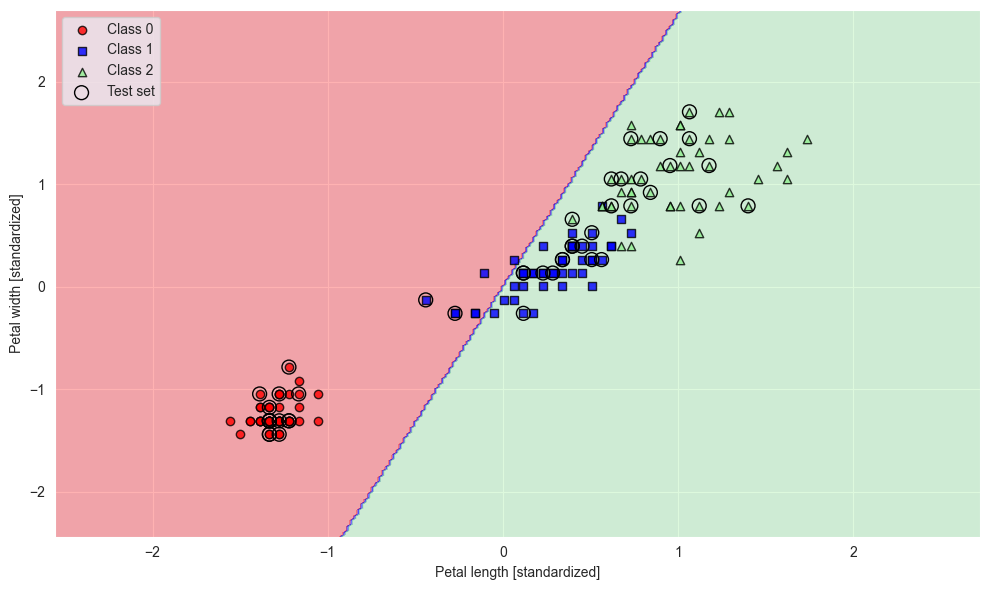

In [634]:

print( 'Decision Regions' )
print( nwln )

X_combined_std = np.vstack( ( X_train_std, X_test_std ) )
y_combined = np.hstack( ( y_train, y_test ) )
plt.figure( figsize=( 10, 6 ) )
plot_decision_regions( X=X_combined_std, y=y_combined, classifier=ppn, test_idx=range( 105, 150 ) )
plt.xlabel( 'Petal length [standardized]' )
plt.ylabel ('Petal width [standardized]' )
plt.legend( loc='upper left' )
plt.tight_layout( )
plt.show( )

#### Sigmoid Function


--------------------------------------------------------------------------------------------------------------------------------------------
Sigmoid Function




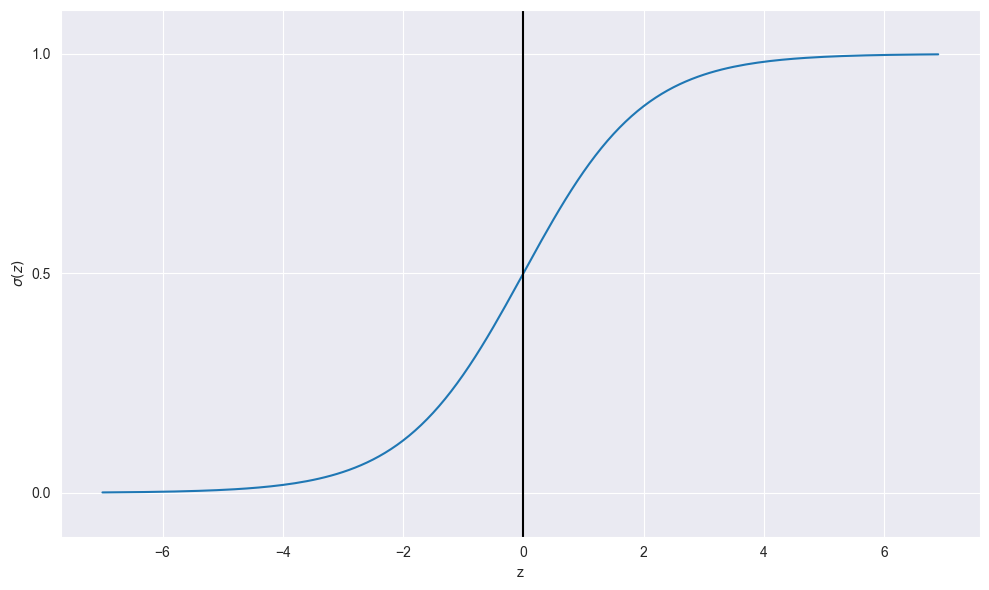

In [571]:
z = np.arange( -7, 7, 0.1 )
plt.figure( figsize=( 10, 6 ) )
sigma_z = sigmoid( z )
plt.plot( z, sigma_z )
plt.axvline( 0.0, color='k' )
plt.ylim( -0.1, 1.1 )
plt.xlabel( 'z' )
plt.ylabel( '$\sigma (z)$' )

print( hdr )
print( 'Sigmoid Function' )
print( nwln )

# y axis ticks and gridline
plt.yticks( [ 0.0, 0.5, 1.0 ] )
ax = plt.gca( )
ax.yaxis.grid( True )
plt.tight_layout( )


#### Loss Function

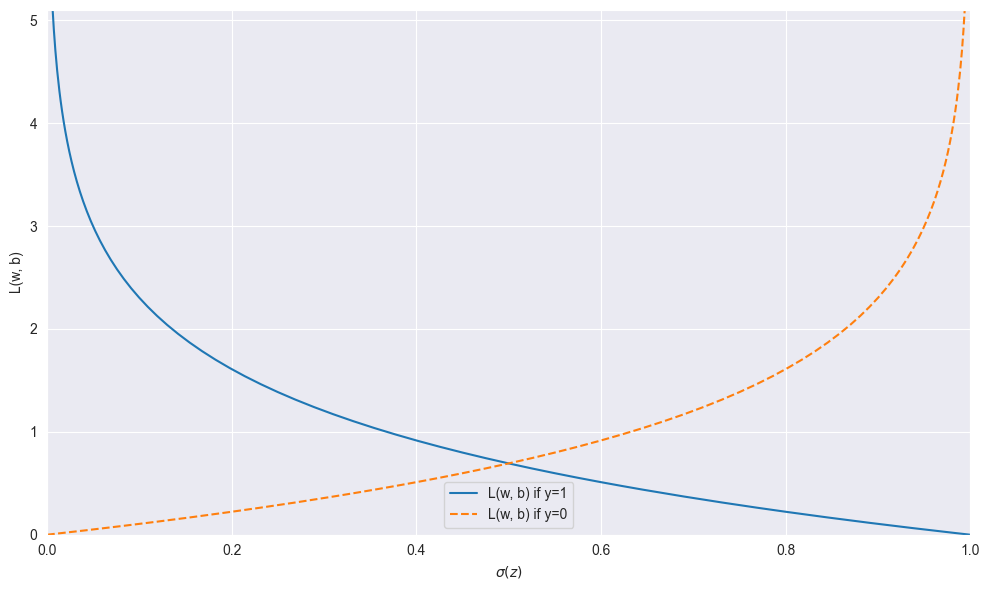

In [572]:

print( nwln )

z = np.arange( -10, 10, 0.1 )
sigma_z = sigmoid( z )
c1 = [ loss_1( x ) for x in z ]
plt.figure( figsize=( 10, 6 ) )
plt.plot( sigma_z, c1, label='L(w, b) if y=1' )
c0 = [ loss_0( x) for x in z]
plt.plot( sigma_z, c0, linestyle='--', label='L(w, b) if y=0' )
plt.ylim( 0.0, 5.1 )
plt.xlim( [ 0, 1 ] )
plt.xlabel( '$\sigma(z)$' )
plt.ylabel( 'L(w, b)' )
plt.legend( loc='best' )
plt.tight_layout( )
plt.show( )

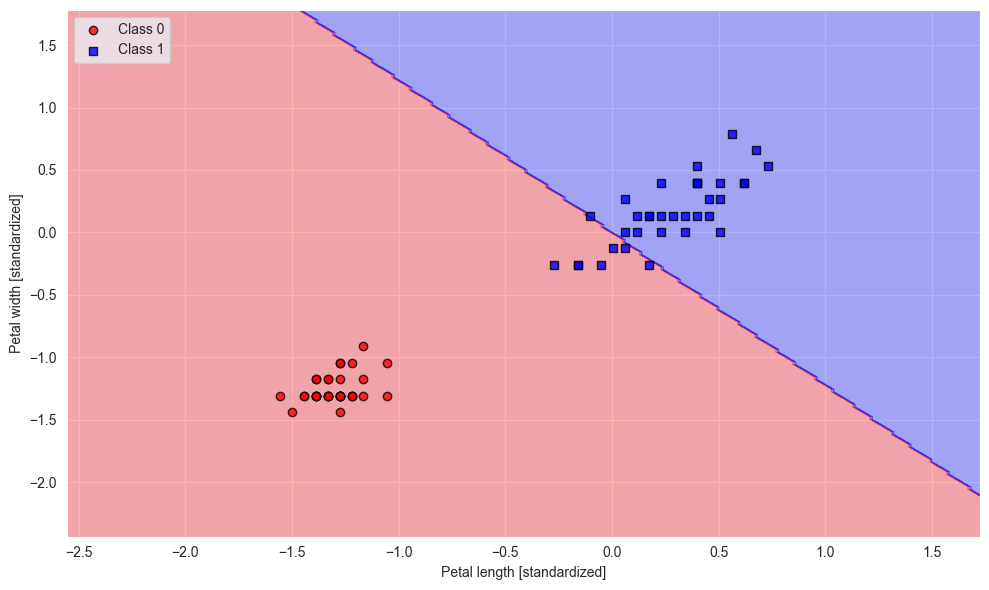

In [635]:

print( nwln )

X_train_01_subset = X_train_std[ ( y_train == 0 ) | ( y_train == 1 ) ]
y_train_01_subset = y_train[ ( y_train == 0 ) | ( y_train == 1 ) ]
lrgd = LogisticGradientDescent( eta=0.3, n_iter=1000, random_state=1 )
lrgd.fit( X_train_01_subset, y_train_01_subset )
plt.figure( figsize=( 10, 6 ) )
plot_decision_regions( X=X_train_01_subset, y=y_train_01_subset, classifier=lrgd )
plt.xlabel( 'Petal length [standardized]' )
plt.ylabel( 'Petal width [standardized]' )
plt.legend( loc='upper left' )
plt.tight_layout( )
plt.show( )

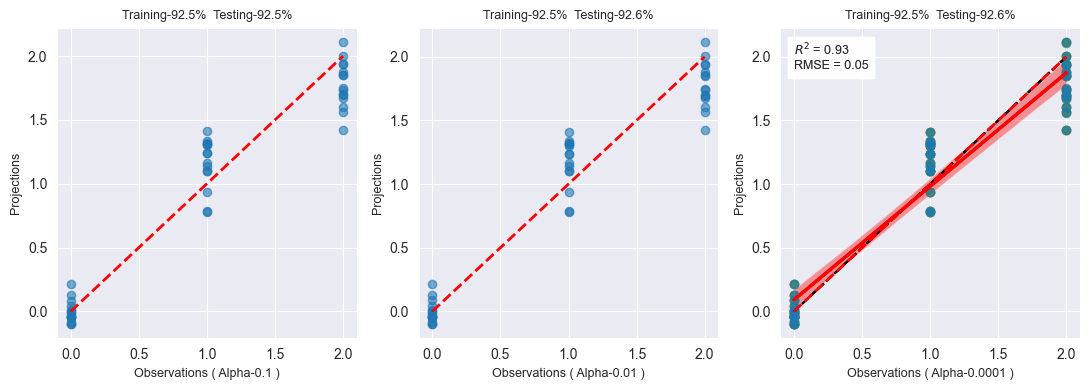

In [640]:
print( nwln )

# Prepare figure for 3 subplots
fig, axes = plt.subplots( 1, 3, figsize=( 11, 4 ) )
alphas = [ .1, .01, .0001 ]

# Train and create_graph for each alpha
for i, a in enumerate( alphas ):
    model = Ridge( alpha=a, max_iter=10000 )
    model.fit( X_train, y_train )
    y_pred_ridge = model.predict( X_test )
    r2 = r2_score( y_test, y_pred_ridge )
    training_score = f'{ model.score( X_train, y_train ):.1%}'
    testing_score = f'{ model.score( X_test, y_test ):.1%}'
    misclassifications = f'{( y_test != y_pred_ridge ).sum( )}'
    rmse = mean_squared_error( y_test, y_pred_ridge )
    if rmse > 100000000:
        rmse = 0.0
    plt.plot( [ y_test.min( ), y_test.max( ) ], [ y_test.min( ), y_test.max( ) ], 'k--', label='Perfect Prediction' )
    sns.regplot( x=y_test, y=y_pred_ridge, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'} )
    plt.text( x=y_test.min( ), y=y_test.max( ) * 0.95,
             s=f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}',
             fontsize=9, bbox=dict(facecolor='white', alpha=0.7 ) )
    axes[ i ].scatter( y_test, y_pred_ridge, alpha=0.6 )
    axes[ i ].create_graph( [ y_test.min( ), y_test.max( ) ], [ y_test.min( ), y_test.max( ) ], 'r--', lw=2 )
    axes[ i ].set_title( f'Training-{training_score}  Testing-{testing_score}', fontsize=9 )
    axes[ i ].set_xlabel( f'Observations ( Alpha-{a} )', fontsize=9 )
    axes[ i ].set_ylabel( 'Projections', fontsize=9 )
    axes[ i ].grid( True )
plt.tight_layout( )
plt.show( )

#### Logistic Regression

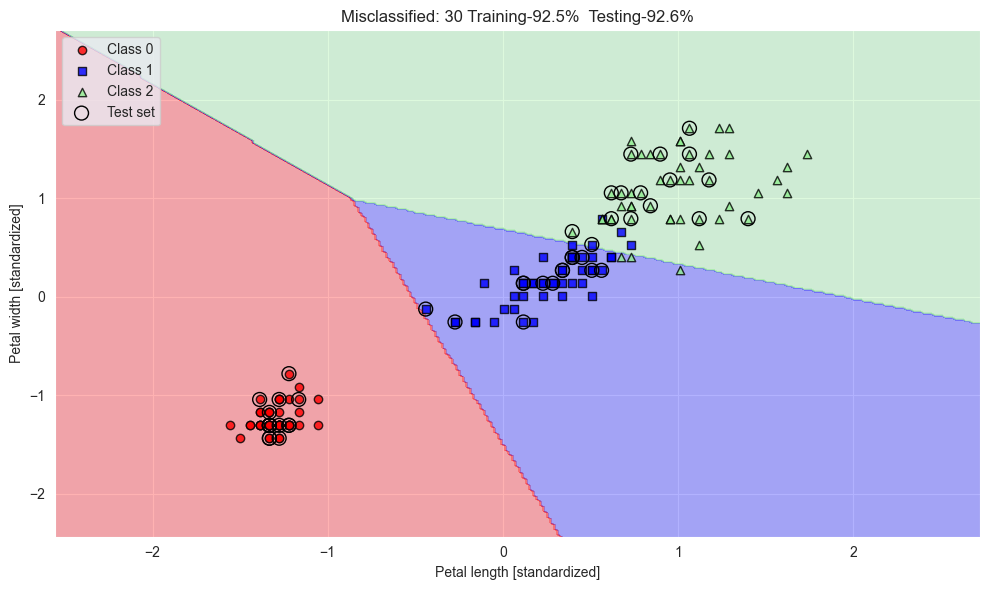

In [644]:
print( nwln )

lr = LogisticRegression( C=1.0, solver='lbfgs', multi_class='ovr' )

plt.figure( figsize=( 10, 6 ) )
lr.fit( X_train_std, y_train )
y_pred_lr_cls = lr.predict( X_test )
misclassifications = f'{( y_test != y_pred_lr_cls ).sum( )}'
plot_decision_regions( X_combined_std, y_combined, classifier=lr, test_idx=range( 105, 150 ) )
plt.title( f'Misclassified: { misclassifications } Training-{training_score}  Testing-{testing_score}' )
plt.xlabel( 'Petal length [standardized]' )
plt.ylabel( 'Petal width [standardized]' )
plt.legend( loc='upper left' )
plt.tight_layout( )
plt.show( )

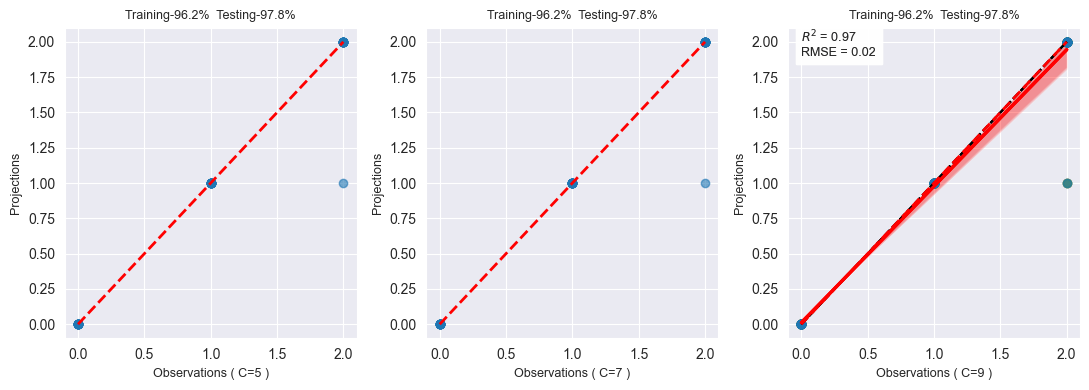

In [628]:
print( nwln )

# Prepare figure for 3 subplots
fig, axes = plt.subplots( 1, 3, figsize=( 11, 4 ) )
alphas = [ 5, 7, 9 ]

# Train and create_graph for each alpha
for i, c in enumerate( alphas ):
    model = LogisticRegression( C=c, solver='lbfgs', multi_class='ovr' )
    model.fit( X_train, y_train )
    y_pred_ridge = model.predict( X_test )
    r2 = r2_score( y_test, y_pred_ridge )
    training_score = f'{ model.score( X_train, y_train ):.1%}'
    testing_score = f'{ model.score( X_test, y_test ):.1%}'
    rmse = mean_squared_error( y_test, y_pred_ridge )
    if rmse > 100000000:
        rmse = 0.0
    plt.plot( [ y_test.min( ), y_test.max( ) ], [ y_test.min( ), y_test.max( ) ], 'k--', label='Perfect Prediction' )
    sns.regplot( x=y_test, y=y_pred_ridge, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'} )
    plt.text( x=y_test.min( ), y=y_test.max( ) * 0.95,
             s=f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}',
             fontsize=9, bbox=dict(facecolor='white', alpha=0.7 ) )
    axes[ i ].scatter( y_test, y_pred_ridge, alpha=0.6 )
    axes[ i ].create_graph( [ y_test.min( ), y_test.max( ) ], [ y_test.min( ), y_test.max( ) ], 'r--', lw=2 )
    axes[ i ].set_title( f'Training-{training_score}  Testing-{testing_score}', fontsize=9 )
    axes[ i ].set_xlabel( f'Observations ( C={c} )', fontsize=9 )
    axes[ i ].set_ylabel( 'Projections', fontsize=9 )
    axes[ i ].grid( True )
plt.tight_layout( )
plt.show( )

In [631]:
print( f'Misclassified: {( y_test != y_pred_ridge ).sum( )}' )
print( f'Accuracy: {accuracy_score( y_test, y_pred_ridge ):.0%}' )

Misclassified: 1
Accuracy: 98%


In [577]:
lr.predict_proba( X_test_std[ :3, : ] )

array([[4.35424381e-04, 2.40133856e-01, 7.59430720e-01],
       [7.98498914e-01, 2.01272655e-01, 2.28430822e-04],
       [8.15960440e-01, 1.83929887e-01, 1.09672897e-04]])

In [578]:
lr.predict_proba( X_test_std[ :3, : ] ).argmax( axis=1 )

array([2, 0, 0], dtype=int64)

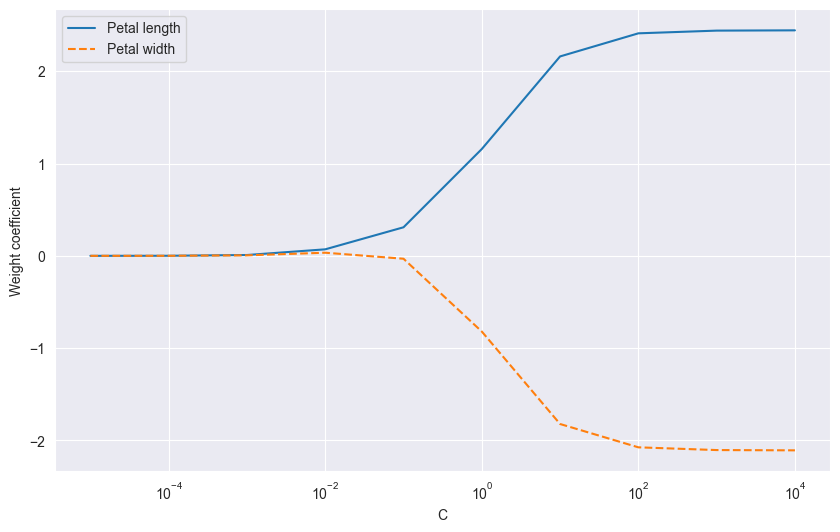

In [579]:

print( nwln )

weights = [ ]
params = [ ]

plt.figure( figsize=( 10, 6 ) )
for c in np.arange( -5, 5 ):
	lr = LogisticRegression( C=10.**c, multi_class='ovr' )
	lr.fit( X_train_std, y_train )
	weights.append( lr.coef_[ 1 ] )
	params.append( 10.**c )
weights = np.array( weights )
plt.plot( params, weights[ :, 0 ], label='Petal length' )
plt.plot( params, weights[ :, 1], linestyle='--', label='Petal width' )
plt.ylabel( 'Weight coefficient' )
plt.xlabel( 'C' )
plt.legend( loc='upper left' )
plt.xscale( 'log' )
plt.show( )

#### SVM Decision Regions

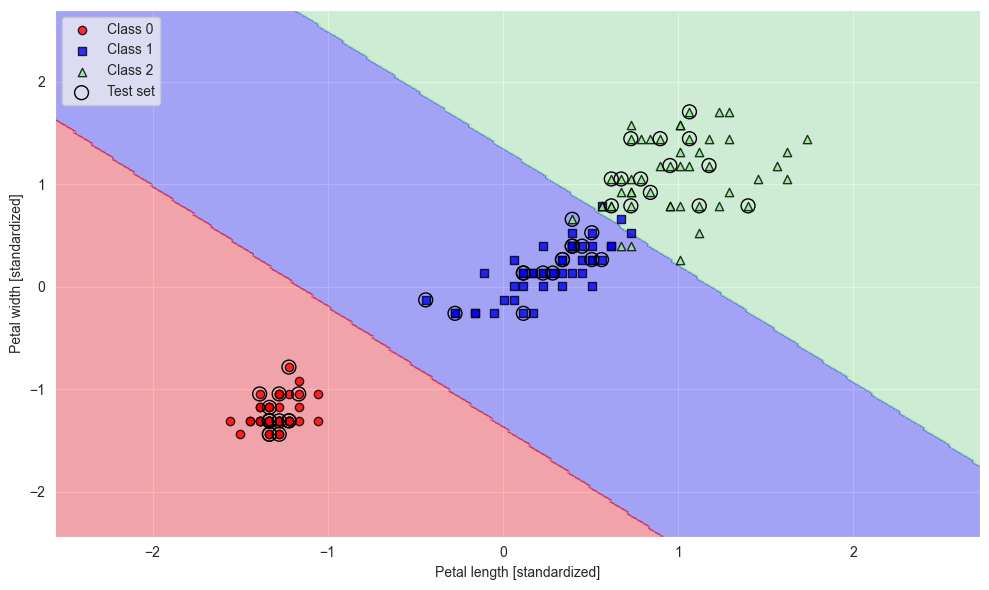

In [580]:

print( nwln )

svm = SVC( kernel='linear', C=1.0, random_state=1 )
svm.fit( X_train_std, y_train )
plt.figure( figsize=( 10, 6 ) )
plot_decision_regions( X_combined_std, y_combined, classifier=svm, test_idx=range( 105, 150 ) )
plt.xlabel( 'Petal length [standardized]' )
plt.ylabel( 'Petal width [standardized]' )
plt.legend( loc='upper left' )
plt.tight_layout( )

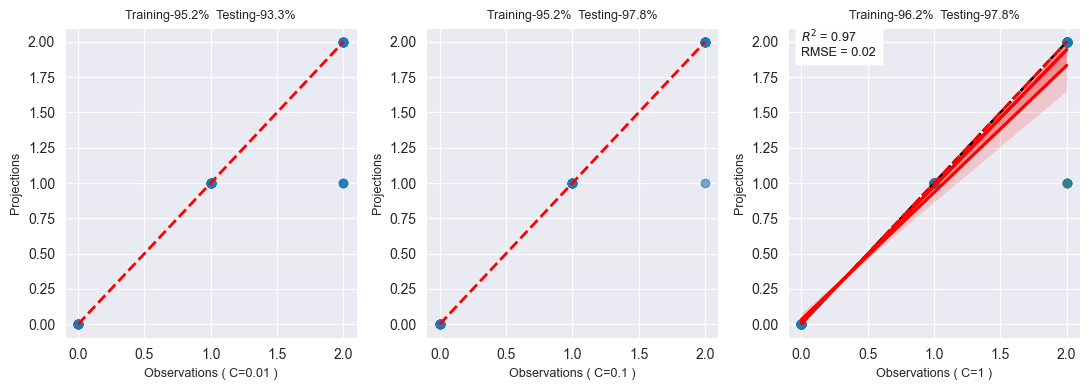

In [597]:
print( nwln )

# Prepare figure for 3 subplots
fig, axes = plt.subplots( 1, 3, figsize=( 11, 4 ) )
alphas = [ .01, .1, 1 ]

# Train and create_graph for each alpha
for i, c in enumerate( alphas ):
    model = SVC( kernel='linear', C=c, random_state=1 )
    model.fit( X_train, y_train )
    y_pred_svm = model.predict( X_test )
    r2 = r2_score( y_test, y_pred_svm )
    training_score = f'{ model.score( X_train, y_train ):.1%}'
    testing_score = f'{ model.score( X_test, y_test ):.1%}'
    rmse = mean_squared_error( y_test, y_pred_svm )
    if rmse > 100000000:
        rmse = 0.0
    plt.plot( [ y_test.min( ), y_test.max( ) ], [ y_test.min( ), y_test.max( ) ], 'k--', label='Perfect Prediction' )
    sns.regplot( x=y_test, y=y_pred_svm, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'} )
    plt.text( x=y_test.min( ), y=y_test.max( ) * 0.95,
             s=f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}',
             fontsize=9, bbox=dict(facecolor='white', alpha=0.7 ) )
    axes[ i ].scatter( y_test, y_pred_svm, alpha=0.6 )
    axes[ i ].create_graph( [ y_test.min( ), y_test.max( ) ], [ y_test.min( ), y_test.max( ) ], 'r--', lw=2 )
    axes[ i ].set_title( f'Training-{training_score}  Testing-{testing_score}', fontsize=9 )
    axes[ i ].set_xlabel( f'Observations ( C={c} )', fontsize=9 )
    axes[ i ].set_ylabel( 'Projections', fontsize=9 )
    axes[ i ].grid( True )
plt.tight_layout( )
plt.show( )

#### Linearly Inseparable Data

In [608]:
ppn = SGDClassifier( loss='perceptron' )
lr = SGDClassifier( loss='log' )
svm = SGDClassifier( loss='hinge' )

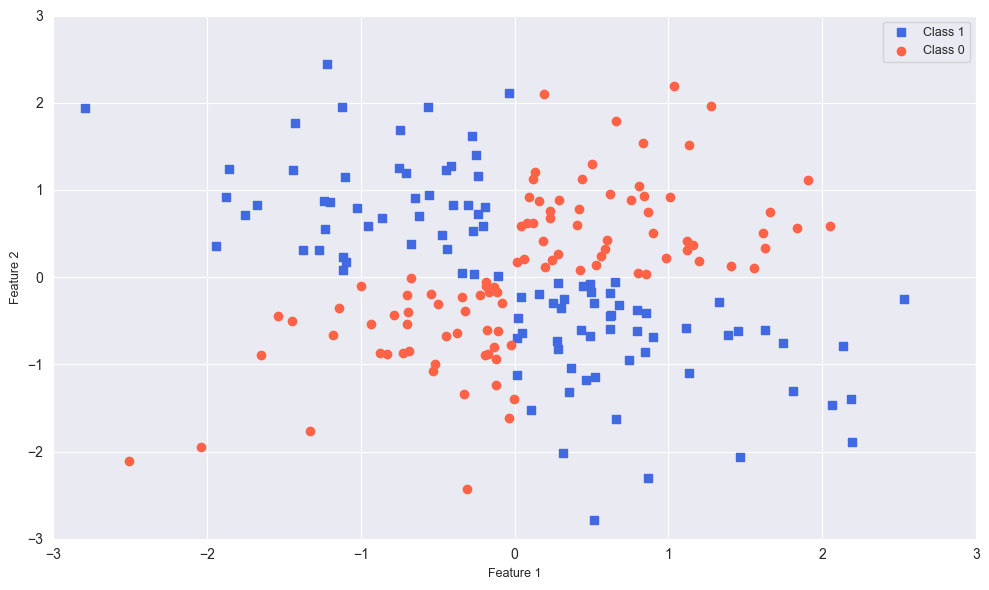

In [612]:

print( nwln )

np.random.seed( 1 )
X_xor = np.random.randn( 200, 2 )
y_xor = np.logical_xor( X_xor[ :, 0 ] > 0, X_xor[ :, 1 ] > 0 )
y_xor = np.where( y_xor, 1, 0 )
plt.figure( figsize=( 10, 6 ) )
plt.scatter( X_xor[ y_xor == 1, 0 ], X_xor[ y_xor == 1, 1 ], c='royalblue', marker='s', label='Class 1' )
plt.scatter( X_xor[ y_xor == 0, 0 ], X_xor[ y_xor == 0, 1 ], c='tomato', marker='o', label='Class 0' )
plt.xlim( [ -3, 3 ] )
plt.ylim( [ -3, 3 ] )
plt.xlabel( 'Feature 1', fontsize=9 )
plt.ylabel( 'Feature 2', fontsize=9 )
plt.legend( loc='best', fontsize=9 )
plt.tight_layout( )
plt.show( )

### SVM


--------------------------------------------------------------------------------------------------------------------------------------------
SVC Kernel Techniques




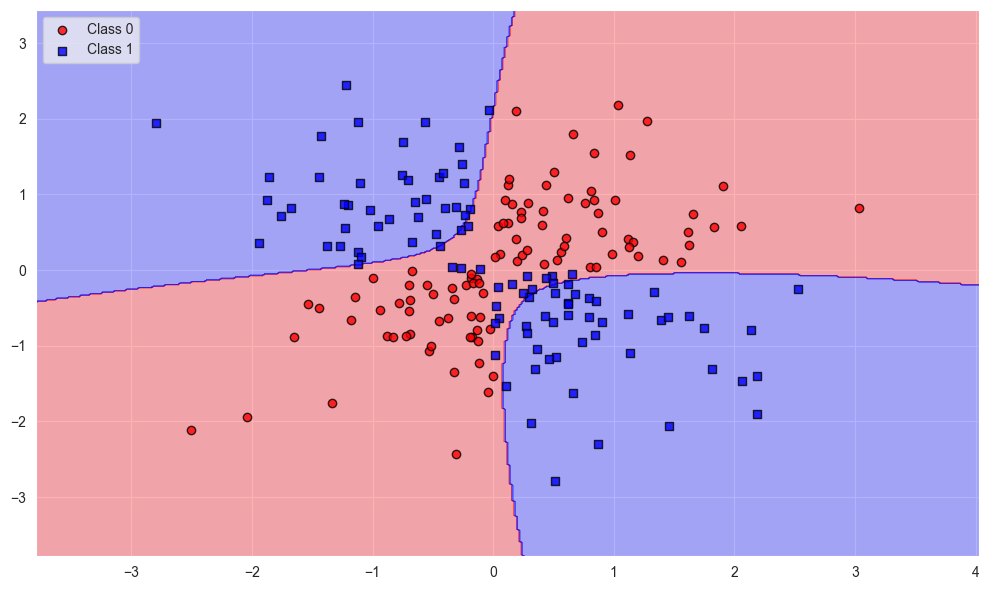

In [599]:
print( hdr )
print( 'SVC Kernel Techniques' )
print( nwln )

plt.figure( figsize=( 10, 6 ) )
svm = SVC( kernel='rbf', random_state=1, gamma=0.10, C=10.0 )
svm.fit( X_xor, y_xor )
plot_decision_regions( X_xor, y_xor, classifier=svm )
plt.legend( loc='upper left' )
plt.tight_layout( )
plt.show( )

In [626]:
print( f'Misclassified: {( y_test != y_pred_svm ).sum( )}' )
print( f'Accuracy: {accuracy_score( y_test, y_pred_svm ):.0%}' )

Misclassified: 1
Accuracy: 98%


#### SVC RBF-Kernel

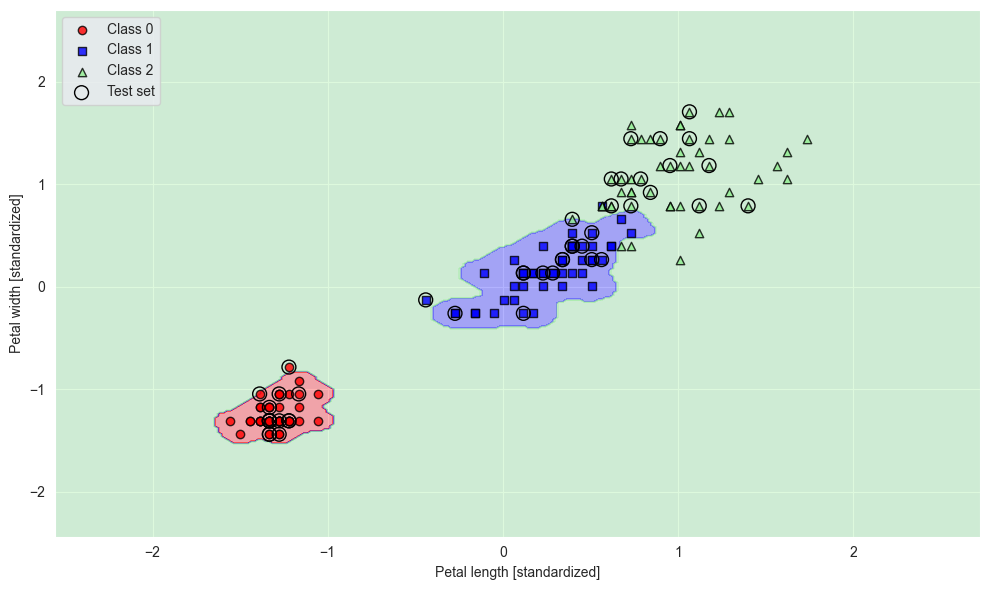

In [586]:

print( nwln )

plt.figure( figsize=( 10, 6 ) )
svm = SVC( kernel='rbf', random_state=1, gamma=100.0, C=1.0 )
svm.fit( X_train_std, y_train )
plot_decision_regions( X_combined_std, y_combined, classifier=svm, test_idx=range( 105, 150 ) )
plt.xlabel( 'Petal length [standardized]' )
plt.ylabel( 'Petal width [standardized]' )
plt.legend( loc='upper left' )
plt.tight_layout( )
plt.show( )

#### Entropy

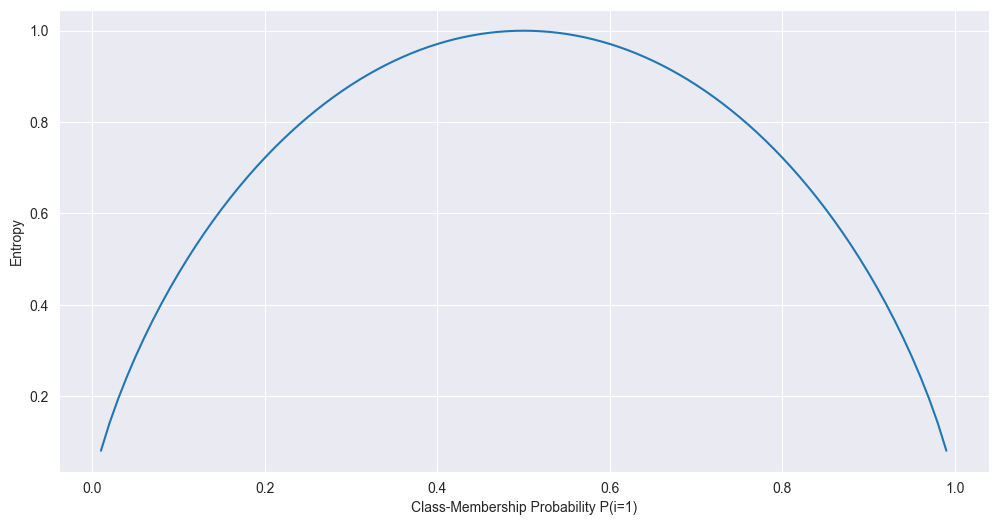

In [587]:

print( nwln )

def entropy( p ):
	return - p * np.log2( p ) - ( 1 - p ) * np.log2( ( 1 - p ) )

plt.figure( figsize=( 12, 6 ) )
x = np.arange( 0.0, 1.0, 0.01 )
ent = [ entropy( p ) if p != 0 else None for p in x ]
plt.ylabel( 'Entropy')
plt.xlabel( 'Class-Membership Probability P(i=1)' )
plt.plot( x, ent )
plt.show( )

#### Gini Impurity

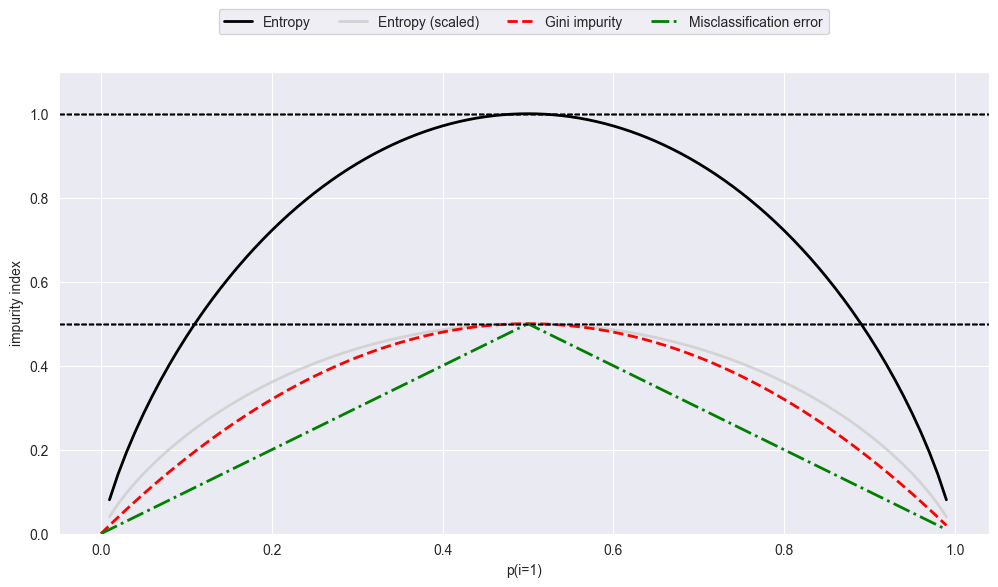

In [588]:

print( nwln )

def gini( p ):
	return p*( 1 - p ) + ( 1 - p )*( 1 - ( 1-p ) )

def entropy( p ):
	return - p*np.log2( p ) - ( 1 - p )*np.log2( ( 1 - p ) )

def error( p ):
	return 1 - np.max( [ p, 1 - p ] )

x = np.arange( 0.0, 1.0, 0.01 )
ent = [ entropy( p ) if p != 0 else None for p in x ]
sc_ent = [ e*0.5 if e else None for e in ent ]
err = [ error( i ) for i in x ]
fig = plt.figure( figsize=( 12, 6 ) )
ax = plt.subplot( 111 )
for i, lab, ls, c, in zip( [ ent, sc_ent, gini( x ), err ], [ 'Entropy', 'Entropy (Scaled)', 'GINI Impurity', 'Misclassification Error' ],
		[ '-', '-', '--', '-.' ], [ 'black', 'lightgray',  'red', 'green', 'cyan' ] ):
	line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c )
	ax.legend( loc='upper center', bbox_to_anchor=( 0.5, 1.15 ), ncol=5, fancybox=True, shadow=False )
	ax.axhline( y=0.5, linewidth=1, color='k', linestyle='--' )
	ax.axhline( y=1.0, linewidth=1, color='k', linestyle='--' )
	plt.ylim( [ 0, 1.1 ] )
	plt.xlabel( 'p(i=1)' )
	plt.ylabel( 'impurity index' )

plt.show( )

#### Building a Decision Tree

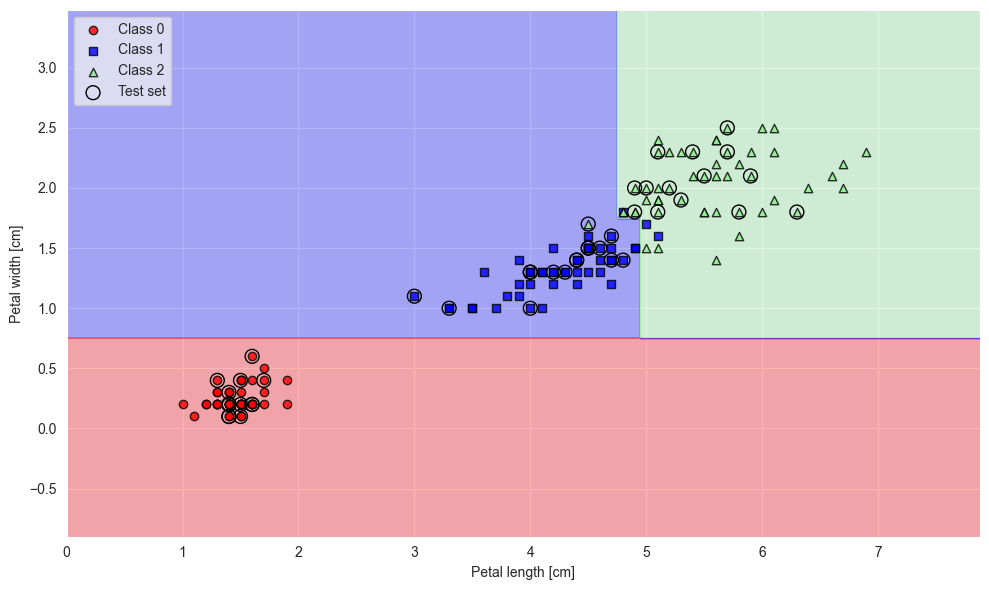

In [589]:

print( nwln )

tree_model = DecisionTreeClassifier( criterion='gini', max_depth=4, random_state=1 )
tree_model.fit( X_train, y_train )
X_combined = np.vstack( ( X_train, X_test ) )
y_combined = np.hstack( ( y_train, y_test ) )
plt.figure( figsize=( 10, 6 ) )
plot_decision_regions( X_combined, y_combined, classifier=tree_model, test_idx=range( 105, 150 ) )
plt.xlabel( 'Petal length [cm]' )
plt.ylabel( 'Petal width [cm]' )
plt.legend( loc='upper left' )
plt.tight_layout( )
plt.show( )

#### Tree Plot

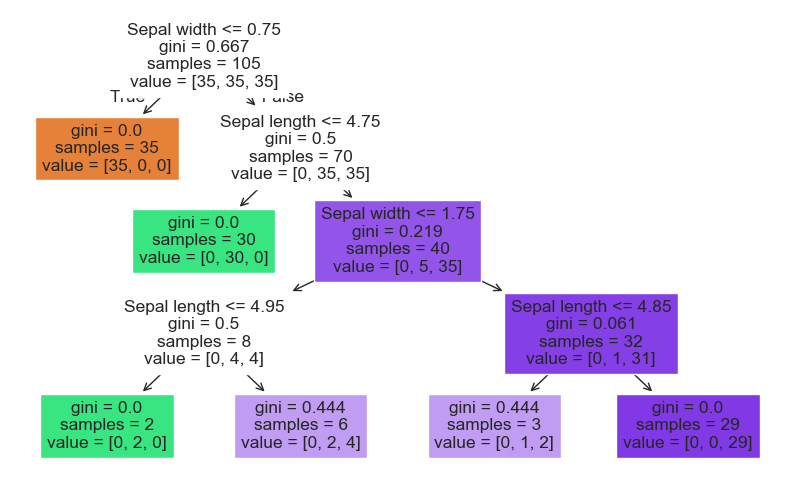

In [590]:

print( nwln )

feature_names = [ 'Sepal length', 'Sepal width', 'Petal length', 'Petal width' ]
plt.figure( figsize=( 10, 6 ) )
tree.plot_tree( tree_model, feature_names=feature_names, filled=True )
plt.show( )

#### Ensemble Methods

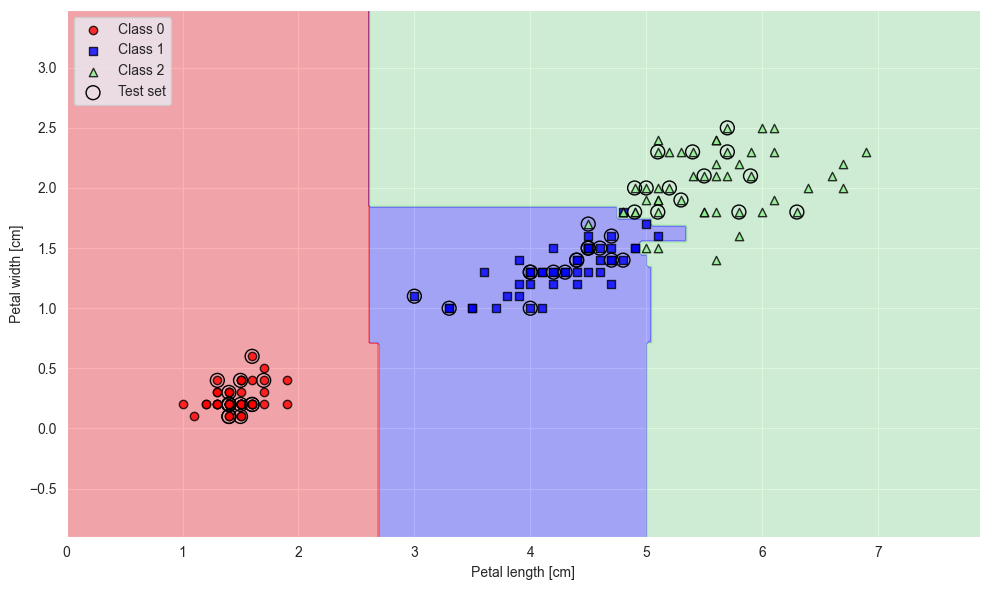

In [591]:
print( nwln )

forest = RandomForestClassifier( n_estimators=25, random_state=1, n_jobs=2 )
forest.fit(X_train, y_train)
plt.figure( figsize=( 10, 6 ) )
plot_decision_regions( X_combined, y_combined, classifier=forest, test_idx=range( 105,150 ) )
plt.xlabel( 'Petal length [cm]' )
plt.ylabel( 'Petal width [cm]' )
plt.legend( loc='upper left' )
plt.tight_layout( )
plt.show( )

#### Nearest Neighbor Classification

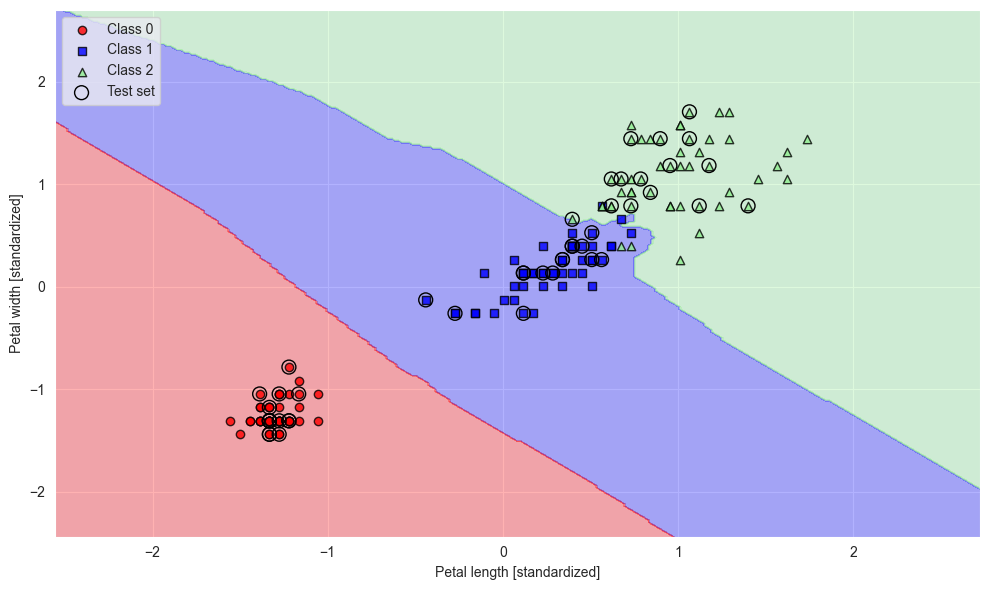

In [592]:
print( nwln )

knn = KNeighborsClassifier( n_neighbors=5, p=2,metric='minkowski' )
knn.fit( X_train_std, y_train )
plt.figure( figsize=( 10, 6 ) )
plot_decision_regions( X_combined_std, y_combined, classifier=knn, test_idx=range( 105,150 ) )
plt.xlabel( 'Petal length [standardized]' )
plt.ylabel( 'Petal width [standardized]' )
plt.legend( loc='upper left' )
plt.tight_layout( )
plt.show( )

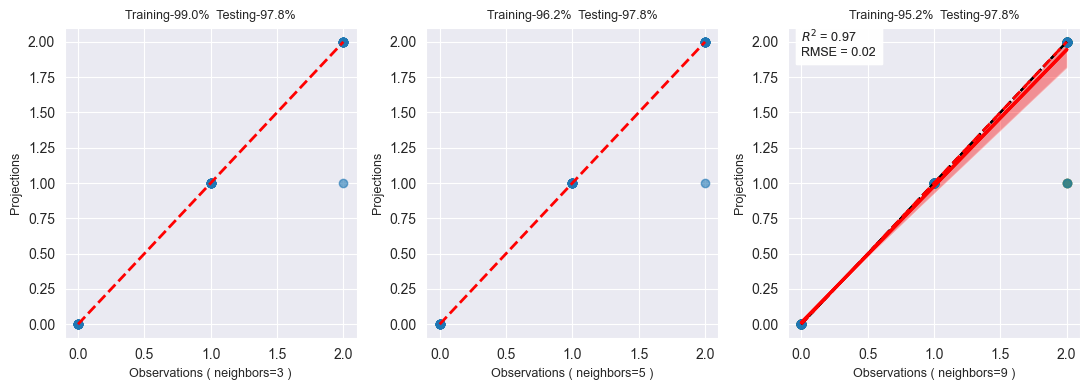

In [593]:
print( nwln )

# Prepare figure for 3 subplots
fig, axes = plt.subplots( 1, 3, figsize=( 11, 4 ) )
alphas = [ 3, 5, 9 ]

# Train and create_graph for each alpha
for i, c in enumerate( alphas ):
    model = KNeighborsClassifier( n_neighbors=c, p=2,metric='minkowski' )
    model.fit( X_train, y_train )
    y_pred_ridge = model.predict( X_test )
    r2 = r2_score( y_test, y_pred_ridge )
    training_score = f'{ model.score( X_train, y_train ):.1%}'
    testing_score = f'{ model.score( X_test, y_test ):.1%}'
    rmse = mean_squared_error( y_test, y_pred_ridge )
    if rmse > 100000000:
        rmse = 0.0
    plt.plot( [ y_test.min( ), y_test.max( ) ], [ y_test.min( ), y_test.max( ) ], 'k--', label='Perfect Prediction' )
    sns.regplot( x=y_test, y=y_pred_ridge, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'} )
    plt.text( x=y_test.min( ), y=y_test.max( ) * 0.95,
             s=f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}',
             fontsize=9, bbox=dict(facecolor='white', alpha=0.7 ) )
    axes[ i ].scatter( y_test, y_pred_ridge, alpha=0.6 )
    axes[ i ].create_graph( [ y_test.min( ), y_test.max( ) ], [ y_test.min( ), y_test.max( ) ], 'r--', lw=2 )
    axes[ i ].set_title( f'Training-{training_score}  Testing-{testing_score}', fontsize=9 )
    axes[ i ].set_xlabel( f'Observations ( neighbors={c} )', fontsize=9 )
    axes[ i ].set_ylabel( 'Projections', fontsize=9 )
    axes[ i ].grid( True )
plt.tight_layout( )
plt.show( )

#### Scatter-Plot Matrix

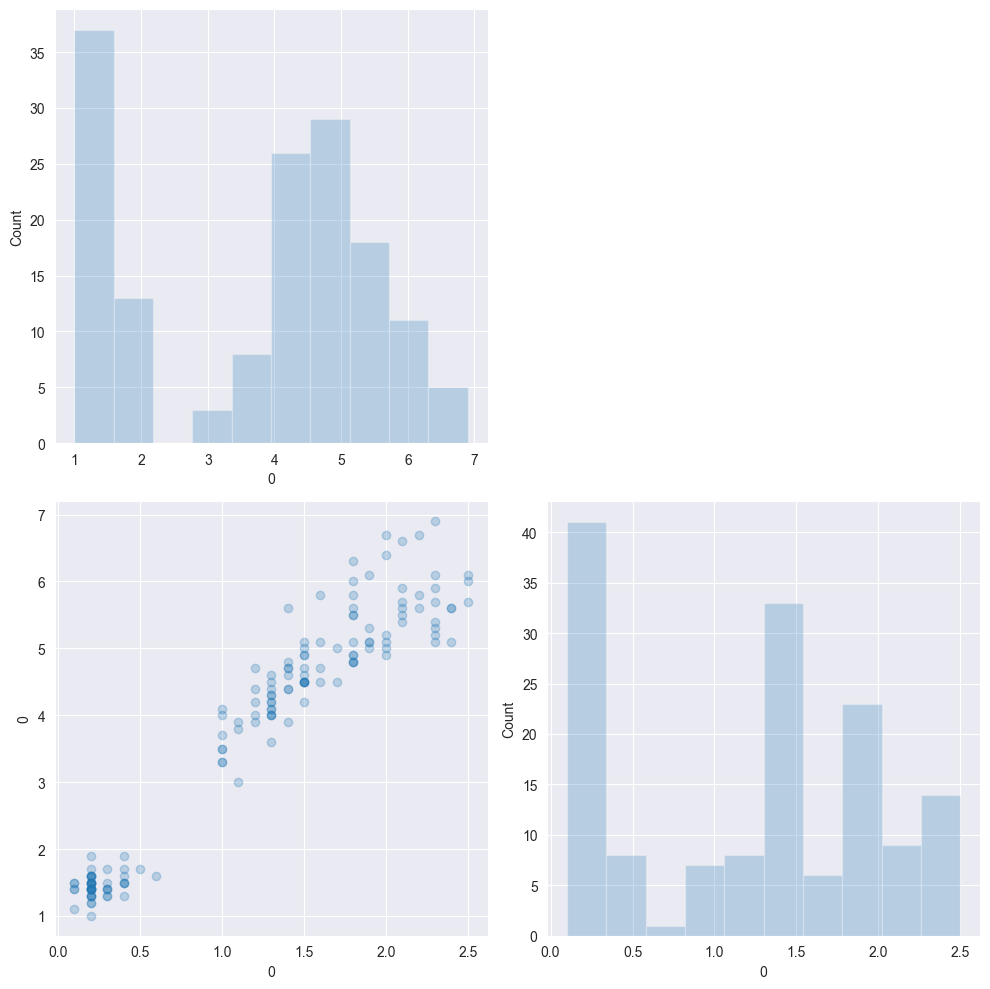

In [594]:
print( nwln )

scatterplotmatrix( X, figsize=( 10, 10 ), names=y, alpha=0.25 )
plt.tight_layout( )
plt.show( )

#### Heatmap

<Figure size 1000x600 with 0 Axes>

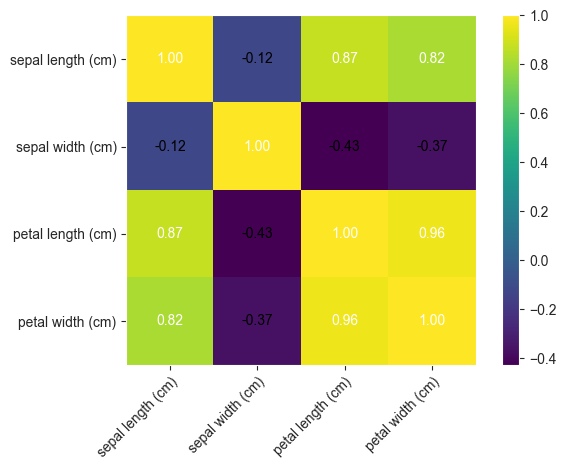

In [595]:
print( nwln )


cm = np.corrcoef( data.T )
plt.figure( figsize=( 10, 6 ) )
hm = heatmap( cm, row_names=targets, column_names=targets  )
plt.tight_layout( )
plt.show( )

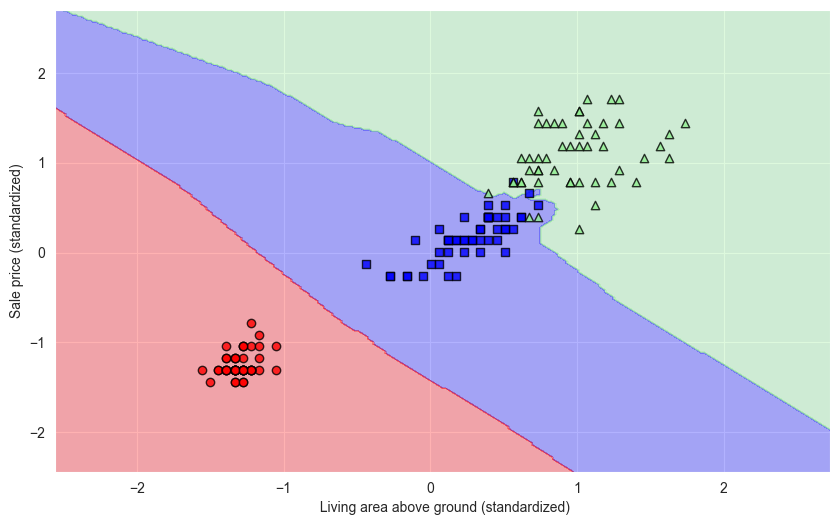

In [596]:
plt.figure( figsize=( 10, 6 ) )
plot_decision_regions( X_combined_std, y_combined, knn )
plt.xlabel( ' Living area above ground (standardized)' )
plt.ylabel( 'Sale price (standardized)' )
plt.show( )